# Importing required modules

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [4]:
# read in an edge list from the file 'test.txt'
G = nx.read_edgelist('./edges.txt', comments='#',
                     create_using=nx.MultiDiGraph(), 
                     delimiter=' ', 
                     nodetype=int, 
                     encoding='utf-8')
nx.info(G)

'MultiDiGraph with 435 nodes and 1528 edges'

## **Before Randomization**

In [5]:
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

In [6]:
print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

# print()
# print("the adjacency list")
# for line in nx.generate_adjlist(G):
#     print(line)

Number of nodes:  435
Number of edges:  1528

Average degree:  7.025287356321839
Average degree (alternate calculation) 7.025287356321839

Minimum degree:  1
Maximum degree:  32


In [7]:
# Calculate average shortest path for all connected nodes in the graph

# Calculate all shortest paths for all connected nodes in the graph first
spDict = dict(nx.all_pairs_shortest_path_length(G))

# Iterate through every node and average their shortest paths and store it into a new dict
avgSPDict = {}

nodes = sorted(list(spDict.keys()))
# Remove the entry that has 0 as a source. Not sure why that is there at all
nodes.remove(0)

# Calculate average sp length for each node that has connections
for node in nodes:
    connectedNodes = list(spDict[node].keys())
    sourceNode = node
    avgSPLength = 0

    # The first entry in connectedNodes is always the source, as the function checks for loops
    # If the connectedNodes for that node is not greater than 1 then there are no other connections

    # Calculate avg shortest path length for nodes with connections
    if len(connectedNodes) > 1:
        for cNode in connectedNodes:
            if sourceNode != cNode:
                avgSPLength += spDict[node][cNode]

        # Find the average of all shortest paths for this node
        avgSPLength = (avgSPLength / (len(connectedNodes) - 1))

        # Update avgSPDict
        avgSPDict[node] = avgSPLength

# Calculate standard deviation of avg shortest paths in the network
# Logic found here : https://www.geeksforgeeks.org/calculate-standard-deviation-of-a-dictionary-in-python/
avgSPList = []
for avgSP in avgSPDict.values():
    avgSPList.append(avgSP)

avgSPSD = np.std(avgSPList)
print(f'The standard deviation for the average shortest paths in our network is {avgSPSD}')

The standard deviation for the average shortest paths in our network is 3.456618753998504


Degree Distribution - Before Randomization

In [8]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

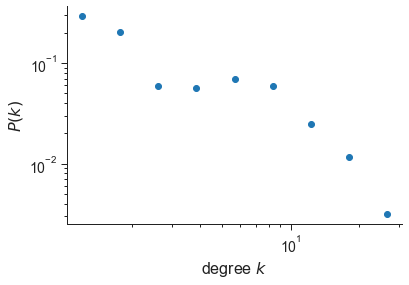

In [9]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

Network - Before Randomization

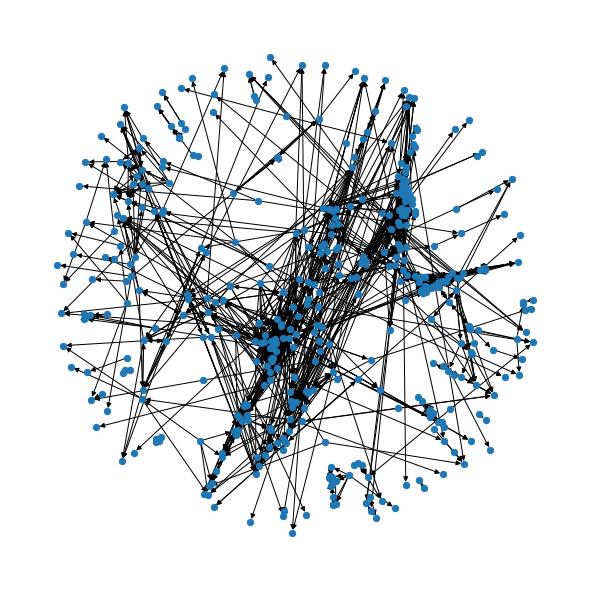

In [10]:
# using the force-based or "spring" layout algorithm
fig = plt.figure(figsize=(8,8))
nx.draw_spring(G, node_size=40)

## **After Randomization**

Create a Random Network using a Configuration Model

In [11]:
inDeg = list(g for N, g in G.in_degree())
outDeg = list(g for N, g in G.out_degree())
R_G = nx.directed_configuration_model(inDeg, outDeg)

R_N = len(G)
R_L = G.size()
R_degrees = [G.degree(node) for node in G]
R_kmin = min(degrees)
R_kmax = max(degrees)
# print()
# print("the adjacency list")
# for line in nx.generate_adjlist(G):
#     print(line)

Create an ensemble of 1000 Random Networks

In [31]:
NUM_RANDOM_NETWORKS = 1000
clusteringCount = 0
pathLengthCount = 0
pathStd = 0
avgPathStdList = []

for _ in range(NUM_RANDOM_NETWORKS):
  # Create a random network using directed_configuration_model
  inDeg = list(g for N, g in G.in_degree())
  outDeg = list(g for N, g in G.out_degree())
  R_G = nx.directed_configuration_model(inDeg, outDeg)

  # Remove parallel edges from R_G because clustering coeffecient doesnt work for multigraph types
  R_G2 = nx.Graph(R_G)

  # Average clustering coeffcient of the current network
  cc = nx.average_clustering(R_G2)
  clusteringCount += cc

  # Average shortest path length of the current network
  # Calculate average shortest path for all connected nodes in the graph

  # Calculate all shortest paths for all connected nodes in the graph first
  spDict = dict(nx.all_pairs_shortest_path_length(R_G))

  # Iterate through every node and average their shortest paths and store it into a new dict
  avgSPDict = {}

  nodes = sorted(list(spDict.keys()))
  # Remove the entry that has 0 as a source. Not sure why that is there at all
  nodes.remove(0)

  # Calculate average sp length for each node that has connections
  for node in nodes:
      connectedNodes = list(spDict[node].keys())
      avgSPLength = 0

      # The first entry in connectedNodes is always the source, as the function checks for loops
      # If the connectedNodes for that node is not greater than 1 then there are no other connections

      # Calculate avg shortest path length for nodes with connections
      if len(connectedNodes) > 1:
          for cNode in connectedNodes:
              if node != cNode:
                  avgSPLength += spDict[node][cNode]

          # Find the average of all shortest paths for this node
          # We subtract 1 to account of the entry that checks if the source node has a conenction to itself
          avgSPLength = (avgSPLength / (len(connectedNodes) - 1))

          # Update avgSPDict
          avgSPDict[node] = avgSPLength

  # Calculate standard deviation of avg shortest paths in the network
  # Logic found here : https://www.geeksforgeeks.org/calculate-standard-deviation-of-a-dictionary-in-python/
  avgSPList = []
  for avgSP in avgSPDict.values():
      avgSPList.append(avgSP)

  avgSPSD = np.std(avgSPList)
  print(f'The standard deviation for the average shortest paths in the random network is {avgSPSD}')
  avgPathStdList.append(avgSPSD)

pathStd = np.average(avgPathStdList)
print(f'The average standard deviation based off {NUM_RANDOM_NETWORKS} randomly generated networks avg shortest path standard deviation is {pathStd}')

#   # print("length.values", sp2)
#   # print(df)
#   spStd = np.std(df)
#   # print(np.std(df))
#   pathLengthCount += sp
#   pathStd += spStd
#   print(spStd)

# # Print Statements
# clusteringAverage = clusteringCount/NUM_RANDOM_NETWORKS
# print("Average Clustering Coefficient", clusteringAverage)
# pathLengthAverage = pathLengthCount/NUM_RANDOM_NETWORKS
# print("Average Path Length ", pathLengthAverage)
# print("Average Path Length Standard Deviation ")
# # Print 


The standard deviation for the average shortest paths in the random network is 0.9112353139412178
The standard deviation for the average shortest paths in the random network is 0.9214714672366133
The standard deviation for the average shortest paths in the random network is 0.8993085205427058
The standard deviation for the average shortest paths in the random network is 0.9519435365135659
The standard deviation for the average shortest paths in the random network is 0.9418125569918879
The standard deviation for the average shortest paths in the random network is 0.8875969565894629
The standard deviation for the average shortest paths in the random network is 0.8729162138990028
The standard deviation for the average shortest paths in the random network is 0.9265161899331257
The standard deviation for the average shortest paths in the random network is 0.9128141650699688
The standard deviation for the average shortest paths in the random network is 0.8466148202632573
The standard deviati

In [ ]:

# # Print Statements
# clusteringAverage = clusteringCount/NUM_RANDOM_NETWORKS
# print("Average Clustering Coefficient", clusteringAverage)
# pathLengthAverage = pathLengthCount/NUM_RANDOM_NETWORKS
# print("Average Path Length ", pathLengthAverage)
# print("Average Path Length Standard Deviation ")
# # Print 


Degree Distribution - After Randomization

In [13]:
# Get 10 logarithmically spaced bins between kmin and kmax
R_bin_edges = np.logspace(np.log10(R_kmin), np.log10(R_kmax), num=10)

# histogram the data into these bins
R_density, _ = np.histogram(R_degrees, bins=bin_edges, density=True)

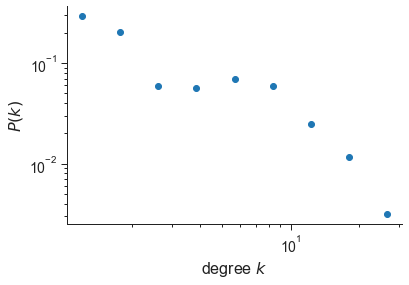

In [14]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(R_bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, R_density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

Network - After Randomization

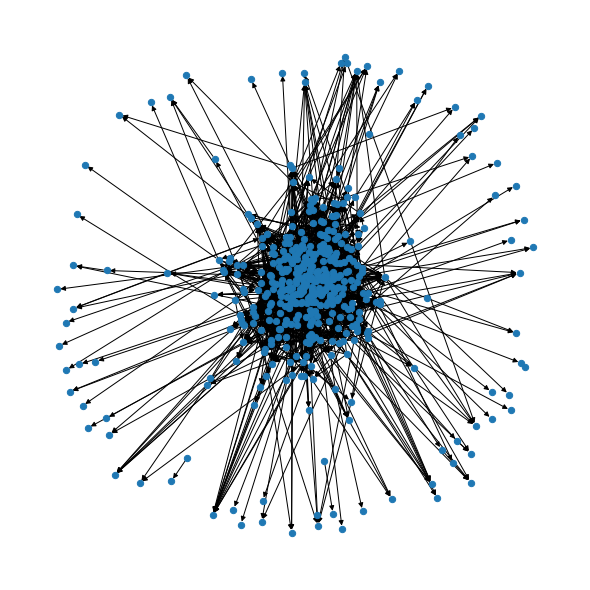

In [15]:
# using the force-based or "spring" layout algorithm
fig = plt.figure(figsize=(8,8))
R_G.remove_edges_from(nx.selfloop_edges(R_G))
nx.draw_spring(R_G, node_size=40)